# Doppler Shift

We take $v_{out}$ with $v_{rot_0} = 0$ km/s. Then we Doppler shift it to reproduce $v_{out}$ with $v_{rot}$. The combinations for each of the 3 taus are:

* $v_{rot} = 50$ km/s and $v_{out} = 25$ km/s
* $v_{rot} = 50$ km/s and $v_{out} = 50$ km/s
* $v_{rot} = 50$ km/s and $v_{out} = 75$ km/s -> data vout=75?
* $v_{rot} = 100$ km/s and $v_{out} = 25$ km/s
* $v_{rot} = 100$ km/s and $v_{out} = 50$ km/s
* $v_{rot} = 100$ km/s and $v_{out} = 75$ km/s -> data vout=75?

This is an example:

![example](../../paper/figures/rotation_doppler_outflow.png)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import os

% matplotlib inline

In [2]:
def read_data(vrot=0, vout=5, logtau=5, input_dir="../../data/"):
    tau_name = 'tau10E' + str(logtau)
    vrot_name = 'vrot' + str(vrot)
    vout_name = 'vout' + str(vout)
    filename = tau_name + '_' + vrot_name + '_' + vout_name + '_out.ascii'
    fname =  os.path.join(input_dir, tau_name, vrot_name, vout_name, filename)

    dtype=[('x', 'f8'),('y', 'f8'), ('z', 'f8'),
           ('k_x', 'f8'),('k_y', 'f8'),('k_z', 'f8'),
           ('x_frec', 'f8'), ('escaped', 'i8'), ('n_scattering', 'i8')]

    df = np.loadtxt(fname, skiprows=1, dtype=dtype)
    df = df[df['escaped']==0]
    return df

In [3]:
def get_angles(num_thetas, num_phis):
    '''Get the angles'''
    cos_thetas = np.linspace(0,1,num_thetas+1) 
    cos_thetas_plus = np.linspace(-1,0,num_thetas+1)
    thetas = np.sort(np.arccos(cos_thetas))
    thetas_plus = np.arccos(cos_thetas_plus)
    phis = np.linspace(0,2*np.pi,num_phis+1) 
    return thetas, thetas_plus, phis

def get_unit_r_sphere(data):
    '''Re-scale positions on the sphere at which the photons escaped'''
    r_norm = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)
    x_sphere = data['x'] / r_norm
    y_sphere = data['y'] / r_norm
    z_sphere = data['z'] / r_norm
    return x_sphere, y_sphere, z_sphere

# Auxiliar functions

def filter_by_theta(data, theta_min, theta_max):
    '''Return only the x_frec_escaped between those upper and lower angles'''
    
    cos_theta_k_out = np.abs(data['k_z'])
    ii = (cos_theta_k_out<np.abs(np.cos(theta_min))) 
    ii = ii &   (cos_theta_k_out>np.abs(np.cos(theta_max)))
    return data[ii]

def get_atom_velocities(x_unitary, y_unitary, z_unitary, vrot):
    '''Defines new atom velocities based on vrot (vr) '''
    v_x = - y_unitary * vrot
    v_y = x_unitary * vrot
    v_z = np.zeros(len(z_unitary))
    return {'x':v_x, 'y':v_y, 'z':v_z}

def doppler_shift(data, vrot=0.0, v_th=12.86):
    '''updates old_data adding doppler shifts. the result is stored in new_data'''
    
    new_data = data.copy()
    
    new_data['x'], new_data['y'], new_data['z'] = get_unit_r_sphere(data)
    
    atom_velocities = get_atom_velocities(
                        new_data['x'], new_data['y'], new_data['z'], vrot=vrot)
    
    new_data['x_frec'] = data['x_frec'] 
    new_data['x_frec'] += atom_velocities['x']*data['k_x']/v_th
    new_data['x_frec'] += atom_velocities['y']*data['k_y']/v_th
    new_data['x_frec'] += atom_velocities['z']*data['k_z']/v_th
    
    return new_data

In [4]:
def plot_spectra(data, min_theta, max_theta, alpha=1.0, v_th=12.86, lw=2,label='label'):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    a = plt.hist(-data_theta['x_frec']*v_th, histtype='step', 
                 fill=False, stacked=False, normed=True, color='black',
                 linewidth=lw, bins=50, alpha=alpha, label=label)

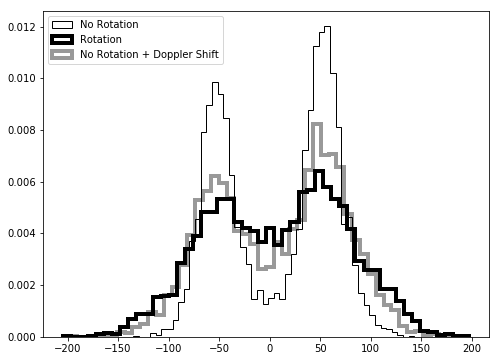

In [5]:
# We are going to transform data_A to rewrite data_C and compare it against data_B
data_A = read_data(vout=5, vrot=0, logtau=5)
data_B = read_data(vout=5, vrot=100, logtau=5)
data_C = doppler_shift(data_A, vrot=100.0)
fig = plt.figure(1, (8., 6.))
mint= np.pi/2.0 -0.05
maxt = np.pi/2.0
plot_spectra(data_A, min_theta=mint, max_theta=maxt, lw=1, label='No Rotation')
plot_spectra(data_B, min_theta=mint, max_theta=maxt, lw=4, label='Rotation')
plot_spectra(data_C, min_theta=mint, max_theta=maxt, lw=4, alpha=0.4, 
            label='No Rotation + Doppler Shift')
plt.legend(loc=2)

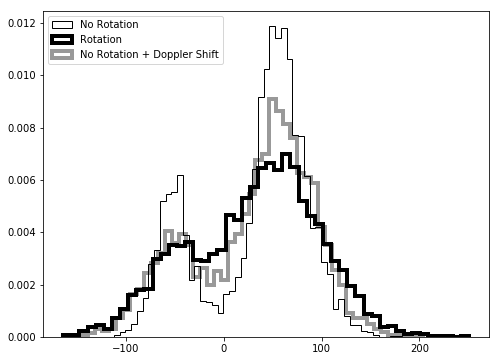

In [6]:
data_A = read_data(vout=25, vrot=0, logtau=5)
data_B = read_data(vout=25, vrot=100, logtau=5)
data_C = doppler_shift(data_A, vrot=100.0)
fig = plt.figure(1, (8., 6.))
mint= np.pi/2.0 -0.05
maxt = np.pi/2.0
plot_spectra(data_A, min_theta=mint, max_theta=maxt, lw=1, label='No Rotation')
plot_spectra(data_B, min_theta=mint, max_theta=maxt, lw=4, label='Rotation')
plot_spectra(data_C, min_theta=mint, max_theta=maxt, lw=4, alpha=0.4, 
            label='No Rotation + Doppler Shift')
plt.legend(loc=2)

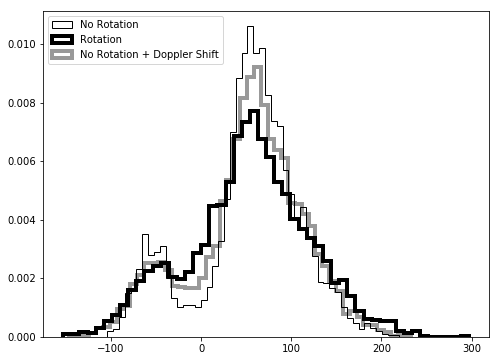

In [7]:
data_A = read_data(vout=50, vrot=0, logtau=5)
data_B = read_data(vout=50, vrot=100, logtau=5)
data_C = doppler_shift(data_A, vrot=100.0)
fig = plt.figure(1, (8., 6.))
mint= np.pi/2.0 -0.05
maxt = np.pi/2.0
plot_spectra(data_A, min_theta=mint, max_theta=maxt, lw=1, label='No Rotation')
plot_spectra(data_B, min_theta=mint, max_theta=maxt, lw=4, label='Rotation')
plot_spectra(data_C, min_theta=mint, max_theta=maxt, lw=4, alpha=0.4, 
            label='No Rotation + Doppler Shift')
plt.legend(loc=2)

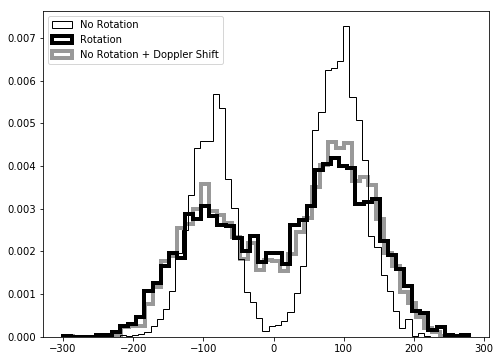

In [8]:
data_A = read_data(vout=5, vrot=0, logtau=6)
data_B = read_data(vout=5, vrot=100, logtau=6)
data_C = doppler_shift(data_A, vrot=100.0)
fig = plt.figure(1, (8., 6.))
mint= np.pi/2.0 -0.05
maxt = np.pi/2.0
plot_spectra(data_A, min_theta=mint, max_theta=maxt, lw=1, label='No Rotation')
plot_spectra(data_B, min_theta=mint, max_theta=maxt, lw=4, label='Rotation')
plot_spectra(data_C, min_theta=mint, max_theta=maxt, lw=4, alpha=0.4, 
            label='No Rotation + Doppler Shift')
plt.legend(loc=2)

# Figure: fig:doppler_shift

In [9]:
def plot_spectra_gridcell(grid_i, data, min_theta, max_theta, alpha=1.0, v_th=12.86, lw=2,label='label'):
    data_theta = filter_by_theta(data, min_theta, max_theta)
    grid_i.hist(-data_theta['x_frec']*v_th, histtype='step', 
                fill=False, stacked=False, normed=True, color='black',
                linewidth=lw, bins=50, alpha=alpha, label=label)

In [10]:
plt.rc('text', usetex=True)
plt.rc('font', size=20)

In [11]:
def plot_doppler_grid(logtau, xmin=-150, xmax=200, ymin=0, ymax=0.0125):
    vrot0 = 0
    vrots = [50,100]
    vouts = [5,25,50]

    num_rows, num_cols = len(vouts), len(vrots)

    fig = plt.figure(1, figsize=(20, 20))
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                     nrows_ncols = (num_rows, num_cols), # creates num_rows x num_cols grid of axes
                     axes_pad=0.3, # pad between axes in inch.
                     aspect=False,)
    props = dict(boxstyle='square', facecolor='white')

    i = 0 # grid cell number
    for vout in vouts:
        for vrot in vrots:

            data_A = read_data(vout=vout, vrot=vrot0, logtau=logtau)
            data_B = read_data(vout=vout, vrot=vrot, logtau=logtau)
            data_C = doppler_shift(data_A, vrot=vrot)

            grid_i = grid[i]

            mint= np.pi/2.0 - 0.05
            maxt = np.pi/2.0
            plot_spectra_gridcell(grid_i, data_A, min_theta=mint, max_theta=maxt, lw=1, label='Outflows')
            plot_spectra_gridcell(grid_i, data_B, min_theta=mint, max_theta=maxt, lw=4, 
                                  label='Outflows + \n Rotation')
            plot_spectra_gridcell(grid_i, data_C, min_theta=mint, max_theta=maxt, lw=4, alpha=0.4, 
                                  label='Outflows + \n Doppler')
            grid_i.legend(loc=2)

            grid_i.set_xlim(xmin,xmax)
            grid_i.set_ylim(ymin,ymax)

            vout_lab = r'$v_{\mathrm{out}}=$ ' + '${0:.0f}$'.format(vout) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'
            vrot_lab = r'$v_{\mathrm{rot}}=$ ' + '${0:.0f}$'.format(vrot) + ' $\mathrm{km}$ $\mathrm{s^{-1}}$'

            if i <= 1:
                grid_i.text((xmin+xmax)/2, ymax*1.1, vrot_lab, bbox=props,
                            horizontalalignment='center', verticalalignment='center')
            if i%2 == 1:
                grid_i.text(xmax*1.1, (ymin+ymax)/2, vout_lab, bbox=props, rotation=270,
                            horizontalalignment='center', verticalalignment='center')
            if i == 2:
                grid_i.set_ylabel('$\mathrm{Intensity}$')
            if i == 4 or i == 5:
                grid_i.set_xlabel('$\mathrm{V}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)')

            i += 1

    plt.savefig('./results/doppler_shift_'+str(logtau)+'.png', format='png', transparent=False, bbox_inches='tight')
    plt.close()

In [12]:
plot_doppler_grid(logtau=5)

In [15]:
plot_doppler_grid(logtau=6, xmin=-200, xmax=300, ymin=0, ymax=0.009)

In [16]:
plot_doppler_grid(logtau=7, xmin=-350, xmax=550, ymin=0, ymax=0.005)

/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/mcrg/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
